In [33]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from python_speech_features import mfcc, logfbank
from python_speech_features import mfcc
import librosa

import pickle
from keras.callbacks import ModelCheckpoint
#from cfg import Config

%matplotlib inline

# and IPython.display for audio output
import IPython.display

# And the display module for visualization
import librosa.display
import warnings
warnings.filterwarnings(action='once')

### Functions to generate the charts that we'll need to

In [3]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


### Creating function to calculate the FFT

In [4]:
def calc_fft(y, rate):
    
    # Get the lenth of y
    n = len(y)
    
    # Getting the frequency
    freq = np.fft.rfftfreq(n , d=1 /rate)

    # Getting the magnitude from complex numbers and normalizing it
    Y = abs(np.fft.rfft(y)/n)
    
    return (Y, freq)
    
    

### Function to apply signal envelope

In [5]:
def envelope(y, rate, threshold):
    
    mask = []
    y = pd.Series(y).apply(np.abs)
    
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()

    
    for mean in y_mean:
        
        if mean > threshold:
            
            mask.append(True)
        else:
            
            mask.append(False)
            
    return mask
    
    

### Reading Instrument CSV
- Archive that map the name of .wav and your classes

In [6]:
df = pd.read_csv('C:\\instruments.csv')
df.set_index('fname', inplace=True)

In [7]:
df.head()

,label
fname,
5388d14d.wav,Saxophone
c685f05f.wav,Saxophone
36d20ab5.wav,Saxophone
d6665734.wav,Saxophone
7352e28f.wav,Saxophone


In [8]:
# Interacting by the archive to get tha rate and the signal values
for f in df.index:
    rate, signal = wavfile.read('C:\\Users\\filip\\OneDrive\\Área de Trabalho\\Audio_Pre Processing_Classification\\Audio-Classification-master\\wavfiles\\'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

#### Data Frame after calculate the length of audios

In [9]:
df.head()

,label,length
fname,,
5388d14d.wav,Saxophone,4.14
c685f05f.wav,Saxophone,1.54
36d20ab5.wav,Saxophone,4.90
d6665734.wav,Saxophone,10.50
7352e28f.wav,Saxophone,6.24


#### Time length mean of each kind of instrument 

In [10]:
class_dist

label
Acoustic_guitar     6.948667
Bass_drum           1.937333
Cello               5.000667
Clarinet            6.596000
Double_bass         3.206000
Flute               8.054667
Hi-hat              3.357333
Saxophone           7.124000
Snare_drum          3.987333
Violin_or_fiddle    4.530000
Name: length, dtype: float64

### Plotting class distribution
- The objective here is understand the real distribution among the classes, to avoid bias on classification models

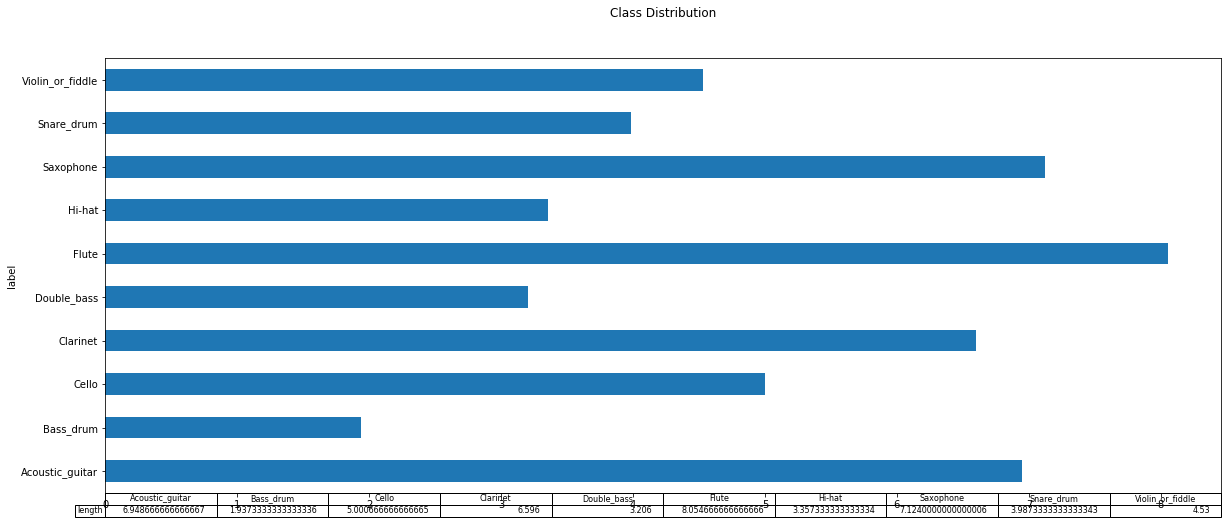

In [11]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title('Class Distribution', y=1.08)
class_dist.plot(kind='barh',table=True)
plt.show()

#### Creating dictionaries

In [12]:
signals ={}
fft = {}
fbank = {}
mfccs = {}

### Interating over each class, reading the audio archives 
- Importing archives
- Reading it with librosa extracting signal and the rate
- Applying FFT (Fourier Transform)

In [13]:
import os

filename = 'C:/Users/filip/OneDrive/Área de Trabalho/Audio_Pre Processing_Classification/Audio-Classification-master/wavfiles/'


for c in classes:
    wav_file = df[df.label == c].index[0]
    path_to = str(filename+wav_file)
    
    
    signal, rate = librosa.load(path_to, sr=44100)
    mask = envelope(signal, rate, 0.0005)
    
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal,rate)
    
    bank = logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate],rate, numcep=13,nfilt=26)   
    mfccs[c] = mel
 


C:\Users\filip\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\audioread\__init__.py:86: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  if ffdec.available():
C:\Users\filip\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\audioread\__init__.py:86: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  if ffdec.available():
C:\Users\filip\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\python_speech_features\sigproc.py:82: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn('frame length (%d) is greater than FFT size (%d), frame will be truncated. Increase NFFT to avoid.', numpy.shape(frames)[1], NFFT)


### Calling chart functions to plot results of Fourier Transformation and Filterbank 

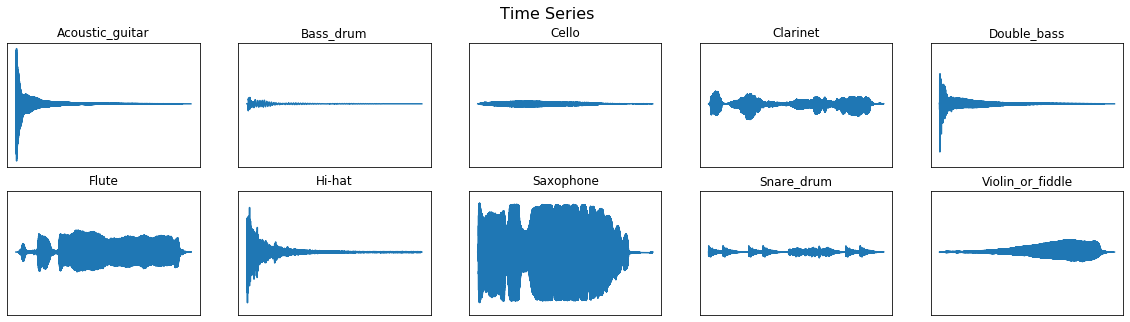

In [14]:
plot_signals(signals)
plt.show()

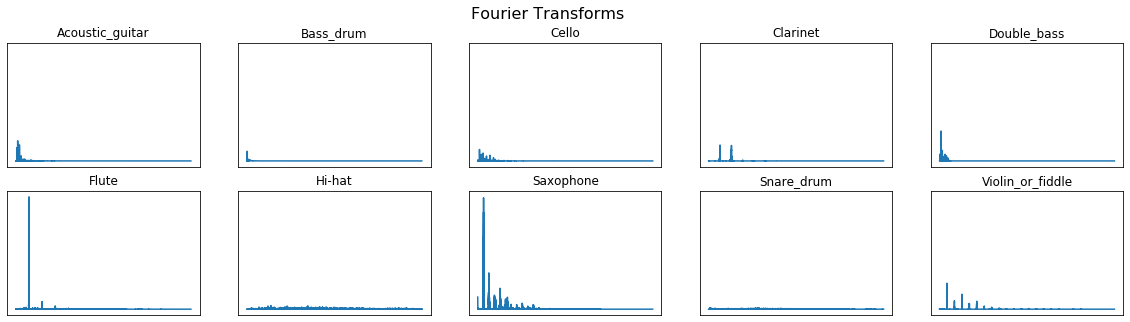

In [15]:
plot_fft(fft)
plt.show()

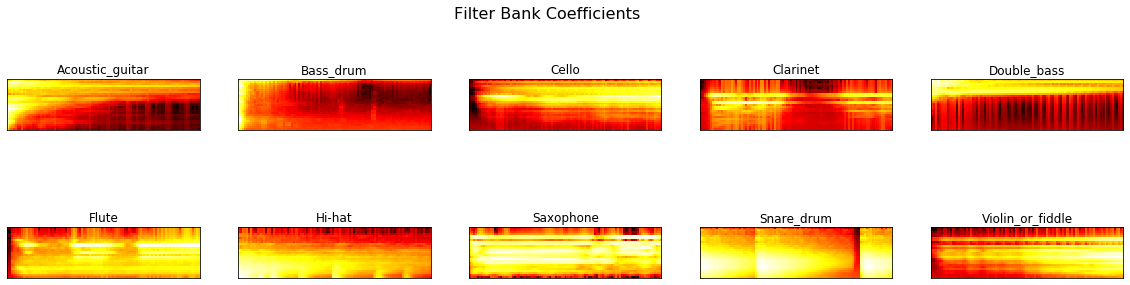

In [16]:
plot_fbank(fbank)
plt.show()

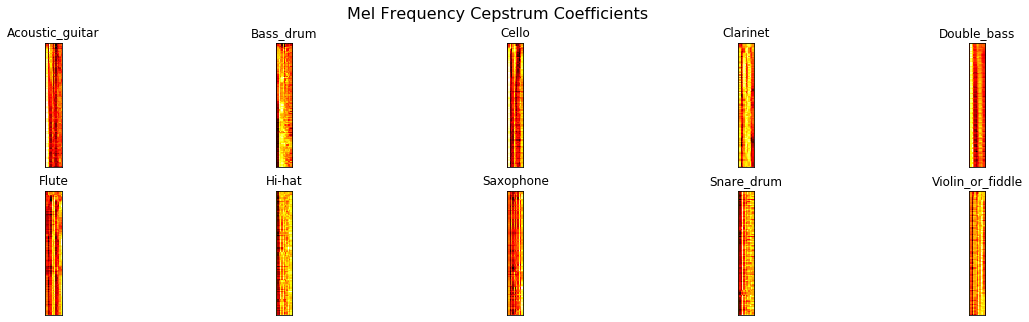

In [17]:
plot_mfccs(mfccs)
plt.show()

In [18]:
if len(os.listdir('C:/Users/filip/OneDrive/Área de Trabalho/Audio_Pre Processing_Classification/Audio-Classification-master/clean')) == 0 :
    for f in tqdm(df.index):
        signal, rate = librosa.load(filename+f, sr=16000)
        mask = envelope(signal,rate, 0.0005)
        wavfile.write(filename='C:/Users/filip/OneDrive/Área de Trabalho/Audio_Pre Processing_Classification/Audio-Classification-master/clean/'+f, rate=rate, data=signal[mask])
        
        

  0%|          | 1/300 [00:00<04:27,  1.12it/s]C:\Users\filip\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\audioread\__init__.py:86: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  if ffdec.available():
C:\Users\filip\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\audioread\__init__.py:86: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  if ffdec.available():
100%|██████████| 300/300 [01:06<00:00,  5.03it/s]


### Now that we'd cleaned audios, lets read each .wav from clean folder to understand it distribution

In [19]:
for f in df.index:
    rate, signal = wavfile.read('C:/Users/filip/OneDrive/Área de Trabalho/Audio_Pre Processing_Classification/Audio-Classification-master/clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

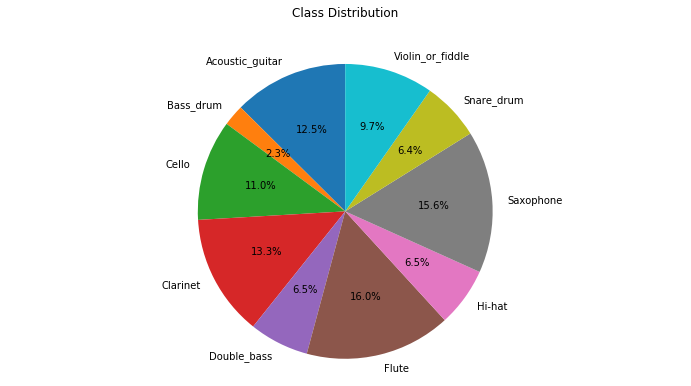

In [20]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [21]:
def check_data():
    if os.path.isfile(config.p_path):
        print('Loadinf existing data for {} model'.format(config.mode))
        
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None



def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0],tmp.data[1]
    
        
        
    X =[]
    y = []
    _min, _max = float('inf'), -float('inf')
    
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('C:/Users/filip/OneDrive/Área de Trabalho/Audio_Pre Processing_Classification/Audio-Classification-master/clean/' + file)
        label = df.at[file,'label']
        rand_index = np.random.randint(0,wav.shape[0] - config.step)
        sample = wav[rand_index:rand_index+config.step]
        #X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)

        _min = min(np.amin(X_sample),_min)
        _max = max(np.amax(X_sample),_max)
        #X.append(X_sample if config.mode == 'conv' else X_sample.T)
        X.append(X_sample)
        y.append(classes.index(label))
    
    config.min = _min
    config.max = _max
    
    X,y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2],1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    
    y = to_categorical(y, num_classes=10)
    
    config.data = (X, y)
    
    
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=2)
    
    return X, y


def get_conv_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1,1),
                    padding='same', input_shape=input_shape))
    
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), 
                    padding='same'))
    
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), 
                    padding='same'))
    
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), 
                    padding='same'))
    
    
    model.add(MaxPool2D((2,2)))
    
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    
    return model


def get_recurrent_model():
    
    #shape of data for RNN is (n, time, feat)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5)) 
    
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

class Config:
    
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
        
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)
        
        self.model_path = os.path.join('C:/Users/filip/OneDrive/Área de Trabalho/Audio_Pre Processing_Classification/Audio-Classification-master/models/',mode + '.model')
        self.p_path = os.path.join('C:/Users/filip/OneDrive/Área de Trabalho/Audio_Pre Processing_Classification/Audio-Classification-master/pickles/', mode + '.p')
        
        
        
        

In [22]:
#Calculating the total length in seconds of my data
n_samples = 2 * int(df['length'].sum() / 0.1)

#probability distribution
prob_dist = class_dist / class_dist.sum()

#Making random choice
choices = np.random.choice(class_dist.index, p=prob_dist)

In [23]:
#config = Config(mode='time')

In [24]:
# if config.mode == 'conv':
#     X, y = build_rand_feat()
#     y_flat = np.argmax(y, axis=1)
#     input_shape = (X.shape[1], X.shape[2], 1)
#     model = get_conv_model()
    
    
# elif  config.mode == 'time':
#     X, y = build_rand_feat()
    
#     y_flat = np.argmax(y, axis=1)
#     input_shape = (X.shape[1], X.shape[2])
#     model = get_recurrent_model()
    

# class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

# model.fit(X, y, epochs=10, batch_size=32, shuffle=True, class_weight=class_weight)



In [25]:
config = Config(mode='conv')

In [27]:
if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
    
    
elif  config.mode == 'time':
    X, y = build_rand_feat()
    
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    

class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max',
                            save_best_only=True, save_weights_only=False, period=1)


#model.fit(X, y, epochs=10, batch_size=32, shuffle=True, class_weight=class_weight)
model.fit(X, y, epochs=10, batch_size=32, shuffle=True, validation_split=0.1,
         callbacks=[checkpoint])

model.save(config.model_path)



Loadinf existing data for conv model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 9, 13, 16)         160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 13, 32)         4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 13, 64)         18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 6, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 307

### Build Predictions

In [39]:
def build_predictions(audio_dir):
    
    y_true = []
    y_pred = []    
    fn_prob = {}
    
    print('Extracting features from audio')
    
    for fn in tqdm(os.listdir(audio_dir)):
        rate, wav = wavfile.read(os.path.join(audio_dir, fn))
        label = fn2class[fn]
        c = classes.index(label)
        y_prob = []
        
        for i in range(0, wav.shape[0] - config.step, config.step):
            sample = wav[i:i+config.step]
            x = mfcc(sample, rate, numcep=config.nfeat, nfilt = config.nfilt,
                    nfft= config.nfft)
            x = (x - config.min) / (config.max - config.min)
            
            if config.mode == 'conv':
                x= x.reshape(1, x.shape[0],x.shape[1],1)
            elif config.mode == 'time':
                x = np.expend_dims(x, axis=0)
            
            y_hat = model.predict(x)
            y_prob.append(y_hat)
            y_pred.append(np.argmax(y_hat))
            y_true.append(c)
            
        
        fn_prob[fn] = np.mean(y_prob, axis=0).flatten()
        
    return y_true, y_pred, fn_prob

    
df = pd.read_csv('C:\\instruments.csv')
classes = list(np.unique(df.label))
fn2class = dict(zip(df.fname, df.label))
p_path = os.path.join('C:/Users/filip/OneDrive/Área de Trabalho/Audio_Pre Processing_Classification/Audio-Classification-master/pickles/', 'conv.p')


with open(p_path, 'rb') as handle:
    
    config = pickle.load(handle)
    
model = load_model(config.model_path)

y_true, y_pred, fn_prob = build_predictions('C:/Users/filip/OneDrive/Área de Trabalho/Audio_Pre Processing_Classification/Audio-Classification-master/clean/')


acc_score = accuracy_score(y_true=y_true, y_pred=y_pred)

y_probs = []

for i, row in df.iterrows():
    y_prob = fn_prob[row.fname]
    y_probs.append(y_prob)
    
    for c,p in zip(classes, y_prob):
        df.at[i,c] = p
        
y_pred = [classes[np.argmax(y)] for y in y_probs]
df['y_pred'] = y_pred

df.to_csv('C:/Users/filip/OneDrive/Área de Trabalho/Audio_Pre Processing_Classification/Audio-Classification-master/predictions.csv', index=False)


Extracting features from audio


100%|██████████| 300/300 [00:38<00:00,  6.92it/s]
